<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL-regression-null-estimating-tool/blob/main/Regression%26RNN_AWDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# xmltodict is not a standard Colab module, so need to download and install it every session.
try:
    import xmltodict
    print("module 'xmltodict' is installed")
except ModuleNotFoundError:
  !pip install xmltodict

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
# import statsmodels.api as sm
from functools import reduce
import math

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

import requests
import xmltodict
import datetime
from datetime import timedelta

# Functions

## Helper Functions

In [ ]:
# Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):
  global xml, dict_of_xml, df
  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  
  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  #Send request to server and receive xml document
  xml = requests.post(URL, data=SOAP_current, headers=headers)

  #convert xml document to a dictionary, extract values putting them in a dataframe.  XML's aren't the easiest to parse and extract data from, so this is a nice work around.
  dict_of_xml = xmltodict.parse(xml.text)
  df = dict_of_xml['soap:Envelope']['soap:Body']['ns2:getDataResponse']['return']['values']

  #Null values are given as OrderedDictionaries with lots of text, while actual values are given as strings.  This converts all the OrderedDictionaries into actual null/none values, and converts all values that were given as strings into float numbers.
  df = pd.DataFrame(map(lambda i: float(i) if type(i) == str else None, df))

  #Since invidual dates aren't associated with the values in the xml document, have to create a range of dates bw the begindate and endate, which is then added to the dataframe.
  df['Date'] = pd.date_range(begindate,enddate,freq='d')
  df.columns = [f'{elementCD}','Date']
  df.set_index('Date', inplace=True)

  return df.iloc[:,0].astype(float)  #For some reason converting numbers to floats (request returns them as strings) can only be done in return.

In [ ]:
# Function to Download Multiple Stations at a time from AWDB Web Service.  
# Not the most efficient way as it sends multiple requests.  Should change SOAP to accept multiple inserted stationtriplets in future.

def getData(stations, parameter_of_interest, begindate, enddate): 
  try:
    data_singleDF = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [SOAP_Call(stationtriplets=j,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate) for j in stations])  
    data_singleDF.columns = [f'{j}' for j in stations]
    return data_singleDF
    
  except ValueError:
    print('The value associated with the begindate and/or enddate in the Air-Water Database (AWDB) is null.  Need to either select a different date(s) or update the value(s) using DMP in AWDB.')
  

In [ ]:
#Function that assigns the regression model to be used and its parameters

def regressionModel(regression_model):
  if regression_model == 'Lasso':
    regr = LassoCV(alphas=(0.001,0.01,0.1,1,10,100,1000))
    return regr
  elif regression_model == 'Ridge':
    regr = RidgeCV(alphas=(0.001,0.01,0.1,1,10,100,1000))
    return regr
  elif regression_model == 'SVM':  #support vector machines
    regr = svm.SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
    return regr
  elif regression_model == 'Huber':
    regr = HuberRegressor()
    return regr
  elif regression_model == 'GradientBoost':
    regr = GradientBoostingRegressor(random_state=0, n_estimators=100)
    return regr
  elif regression_model == 'AdaBoost':
    regr = AdaBoostRegressor(random_state=0, n_estimators=100)
    return regr
  elif regression_model == 'Random Forest':                         #Why Random Forest may not be the best for regression and alternatives: https://neptune.ai/blog/random-forest-regression-when-does-it-fail-and-why
    regr = RandomForestRegressor(bootstrap=False, n_estimators=100, max_depth=3, min_samples_leaf = 5)     #Also how to get better results: https://towardsdatascience.com/what-is-model-complexity-compare-linear-regression-to-decision-trees-to-random-forests-7ec837b062a9
    return regr
  else:
    print('Choose either Lasso, Ridge, SVM, Huber, GradientBoost, AdaBoost, or Random Forest')

## Recurrent Neural Network

In progress...

In [ ]:
# help(tf.keras.Model)

In [ ]:
#Connect to TPU to train large models.  Don't use TPU resources if just training small model.

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.5.0
Running on TPU  ['10.19.150.146:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.19.150.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.19.150.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# https://www.youtube.com/watch?v=QIUxPv5PJOY

class RNN2():

  def __init__(self, station, parameter, begindate, enddate):

    self.station = station
    self.parameter = parameter
    self.begindate = begindate
    self.enddate = enddate
    
    df = getData(self.station, self.parameter, self.begindate, self.enddate)
    self.df = df
    #Convert dataframe to a numpy array (already an array)
    self.dataset = np.array(df).reshape(-1,1)

  def traintestsplit(self): #, testsize):
    #Get number of rows to train the model on.
    training_data_len = math.ceil(len(self.dataset) * 0.8)
    self.training_data_len = training_data_len
    # self.testsize = testsize

    # test_ind = len(self.df) - self.testsize
    # train = self.df.iloc[:test_ind] 
    # test = self.df.iloc[test_ind:]
    
    # self.train = pd.DataFrame(train)
    # self.test = pd.DataFrame(test)

  def scale_data(self, length):
    #Note: Length refers to the length of the output sequence (in number of timesteps)
    # In regards to length and batch.  If length = 365 and batch is 1 are essentially saying, "using the past 365 days of data, forecast the next 1 day." 
    # Don't worry if batch is so low.  The values are calculated sequentially, so this doesn't mean it'll only forecast one value; it's just the first iteration of the forecasting.

    #Scale the data set
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(self.dataset)
    
    self.scaler = scaler
    self.scaled_data = scaled_data
    self.length = length

    #Create training data set

    #Create the scaled training data set
    train_data = scaled_data[0:self.training_data_len, :]
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(length, len(train_data)):   #appending the last n (defined by length) values to x_train
      x_train.append(train_data[i-length:i,0])
      y_train.append(train_data[i, 0])
      if i <=length:
        print(x_train)
        print(y_train)


    #Convert x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data.   
    #LTSM expects data to be three dimensional in the form: (# of samples, # of timesteps, # of features)
    #https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    self.x_train = x_train
    self.y_train = y_train

    # scaler.fit(self.train)  #ONLY fit to training data, or else cheating assuming info about test set.
    # scaled_train = scaler.transform(self.train)
    # scaled_test = scaler.transform(self.test)


  def create_model(self):

    # generator = TimeseriesGenerator(self.scaled_train, self.scaled_train, length=length, batch_size=1)

    #Create the model
    n_features = 1
    model = Sequential()
    model.add(LSTM(50, return_sequences = True, activation='relu', input_shape=(self.x_train.shape[1],1)))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(1))

    #Compile model selecting optimizer and loss function.
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    
    self.n_features = n_features
    self.model = model

  def fit(self, patience = 1, batch_size = 1, epochs = 10):

    early_stop = EarlyStopping(monitor='loss', patience=patience)
    # validation_generator = TimeseriesGenerator(self.scaled_test,self.scaled_test, length=self.length, batch_size=1)  #batch is the number of timeseries samples in each batch

    # fit model
    self.model.fit(self.x_train,
                   self.y_train,
                   batch_size=batch_size, 
                   epochs=epochs,
                  #  validation_data=(self.scaled_test, self.scaled_test),
                   callbacks=early_stop,
                   verbose=1) 

    # self.model.fit_generator(self.generator,epochs=20,
    #                     validation_data=validation_generator,
    #                   callbacks=[early_stop])
    losses = pd.DataFrame(self.model.history.history)
    losses.plot()

  #Create the testing data set

  def eval_test_data(self):
    #Create the testing data set
    
    #Create a new array containing scaled values
    test_data = self.scaled_data[self.training_data_len - self.length:,:]
    
    #Create the data sets x_test and y_test
    x_test = []
    y_test = self.dataset[self.training_data_len:, :]
    for i in range(self.length, len(test_data)):
      x_test.append(test_data[i-self.length:i,0])

    #Convert data to a numpy array
    x_test = np.array(x_test)
    #Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  #https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

    #Get the model's predicted values
    test_predictions = self.model.predict(x_test)
    test_predictions = self.scaler.inverse_transform(test_predictions)

    self.x_test = x_test
    self.test_predictions = test_predictions

    #Get RMSE
    rmse = np.sqrt(np.mean(test_predictions - y_test)**2)
    print(f'Root Mean Square Error = {rmse}')

    #Plot the data
    df = pd.DataFrame(self.df)
    train = df.iloc[:self.training_data_len,0]
    valid = df.iloc[self.training_data_len:]
    valid['Predictions'] = test_predictions
    plt.figure(figsize = (16,8))
    plt.plot(train.iloc[:])
    plt.plot(valid.iloc[:,0])
    plt.plot(valid.iloc[:,1])
    plt.legend(['Train','Test','Predictions'], loc = 'lower left') 
    plt.show()

    self.valid = valid


  def predictions(self, forecast_begindate, forecast_enddate, length = 60, num_days_to_forecast = 10):

    df2 = getData(self.station, self.parameter, forecast_begindate, forecast_enddate)

  
    # #Grab last 60 days of values and convert df to array
    # last_n_days = np.array(self.df2[-60:]).reshape(-1,1)
    # #Scale data:
    # last_n_days_scaled = self.scaler.transform(last_n_days)

    # X = np.array([last_n_days_scaled])

    #Reshape the data
    # X = np.reshape(X,(X[0],X[1],1))
    #Get predictions
    # predictions = self.model.predict(X)
    #Undo the scaling
    # predictions = self.scaler.inverse_transform(predictions)

    first_eval_batch = np.array(df2[-length:]).reshape(-1,1)
    # first_eval_batch = first_eval_batch.reshape((first_eval_batch[0], first_eval_batch[1], 1)) #n_input

    first_eval_batch_scaled = model.scaler.transform(first_eval_batch)
    current_batch = np.array([first_eval_batch_scaled])

    # current_batch = first_eval_batch.reshape((1, 60, 1))

    forecasts = []

    for i in range(num_days_to_forecast):
        
        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = model.model.predict(current_batch)[0]
        
        # store prediction
        forecasts.append(current_pred) 
        
        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    true_forecasts = model.scaler.inverse_transform(forecasts)
    true_forecasts = pd.DataFrame(true_forecasts)
    # forecasts_df = pd.DataFrame()
    # forecasts_df['Predictions'] = true_forecasts
    forecast_begindate = datetime.datetime.strptime(forecast_enddate, '%m/%d/%Y') + timedelta(days=1)
    forecast_enddate = datetime.datetime.strptime(forecast_enddate, '%m/%d/%Y') + timedelta(days=num_days_to_forecast)
    true_forecasts['Date'] = pd.date_range(forecast_begindate, forecast_enddate)
    true_forecasts.set_index('Date', inplace=True)
    self.true_forecasts = true_forecasts




  def predictions2(self, last_date_with_data, length = 60, num_days_to_forecast = 10):
    
    begindate = (datetime.datetime.strptime(last_date_with_data, '%m/%d/%Y') - timedelta(days=length+60)).strftime('%m/%d/%Y')
    # begindate = begindate.strftime(begindate)
    df2 = getData(self.station, self.parameter, 
                  begindate, 
                  last_date_with_data)
  
    # #Grab last 60 days of values and convert df to array
    # last_n_days = np.array(self.df2[-60:]).reshape(-1,1)
    # #Scale data:
    # last_n_days_scaled = self.scaler.transform(last_n_days)

    # X = np.array([last_n_days_scaled])

    #Reshape the data
    # X = np.reshape(X,(X[0],X[1],1))
    #Get predictions
    # predictions = self.model.predict(X)
    #Undo the scaling
    # predictions = self.scaler.inverse_transform(predictions)

    first_eval_batch = np.array(df2[-length:]).reshape(-1,1)
    # first_eval_batch = first_eval_batch.reshape((first_eval_batch[0], first_eval_batch[1], 1)) #n_input

    first_eval_batch_scaled = model.scaler.transform(first_eval_batch)
    current_batch = np.array([first_eval_batch_scaled])

    # current_batch = first_eval_batch.reshape((1, 60, 1))

    forecasts = []

    for i in range(num_days_to_forecast):
        
        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = model.model.predict(current_batch)[0]
        
        # store prediction
        forecasts.append(current_pred) 
        
        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    true_forecasts = model.scaler.inverse_transform(forecasts)
    true_forecasts = pd.DataFrame(true_forecasts)
    # forecasts_df = pd.DataFrame()
    # forecasts_df['Predictions'] = true_forecasts
    forecast_begindate = (datetime.datetime.strptime(last_date_with_data, '%m/%d/%Y') + timedelta(days=1)).strftime('%m/%d/%Y')
    forecast_enddate = (datetime.datetime.strptime(last_date_with_data, '%m/%d/%Y') + timedelta(days=num_days_to_forecast)).strftime('%m/%d/%Y')
    true_forecasts['Date'] = pd.date_range(forecast_begindate, forecast_enddate)
    true_forecasts.set_index('Date', inplace=True)
    self.true_forecasts = true_forecasts


# How to save/load models after training: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [ ]:
model = RNN2(['507:WA:SNTL'], 'WTEQ','01/01/2010','05/01/2021')

In [ ]:
model.traintestsplit()

In [ ]:
model.scale_data(365)

[array([0.25367647, 0.26102941, 0.26470588, 0.26470588, 0.29779412,
       0.29779412, 0.30147059, 0.29779412, 0.30882353, 0.3125    ,
       0.3125    , 0.31617647, 0.31617647, 0.34191176, 0.34558824,
       0.34926471, 0.36029412, 0.39705882, 0.40073529, 0.40808824,
       0.41911765, 0.41911765, 0.41911765, 0.41544118, 0.4375    ,
       0.4375    , 0.4375    , 0.4375    , 0.4375    , 0.44117647,
       0.44485294, 0.44485294, 0.44852941, 0.44852941, 0.45220588,
       0.45955882, 0.46691176, 0.46691176, 0.46691176, 0.46691176,
       0.46691176, 0.47058824, 0.49632353, 0.5       , 0.51102941,
       0.51838235, 0.51838235, 0.52941176, 0.52941176, 0.52941176,
       0.52573529, 0.52573529, 0.52205882, 0.52205882, 0.52573529,
       0.52941176, 0.52573529, 0.58455882, 0.58455882, 0.58823529,
       0.58823529, 0.58823529, 0.60294118, 0.59926471, 0.60294118,
       0.60294118, 0.60294118, 0.60294118, 0.59191176, 0.59926471,
       0.60661765, 0.61764706, 0.61764706, 0.61397059, 0.6139

In [ ]:
model.create_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
2947/2947 [==============================] - 394s 133ms/step - loss: 0.0018
Epoch 2/10
2947/2947 [==============================] - 392s 133ms/step - loss: 5.2656e-04
Epoch 3/10
2947/2947 [==============================] - 384s 130ms/step - loss: 3.3072e-04
Epoch 4/10
2947/2947 [==============================] - 383s 130ms/step - loss: 3.0746e-04
Epoch 5/10
2947/2947 [==============================] - 383s 130ms/step - loss: 2.7543e-04
Epoch 6/10
2947/2947 [==============================] - 381s 129ms/step - loss: 2.1688e-04
Epoch 7/10
2947/2947 [==============================] - 386s 131ms/step - loss: 1.9938e-04
Epoch 8/10
2947/2947 [==============================] - 385s 131ms/step - loss: 2.1120e-04


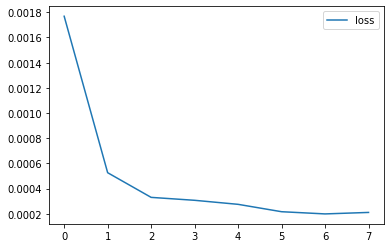

In [ ]:
model.fit(epochs=5)

In [ ]:
# model.train

Root Mean Square Error = 0.6986267820892557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



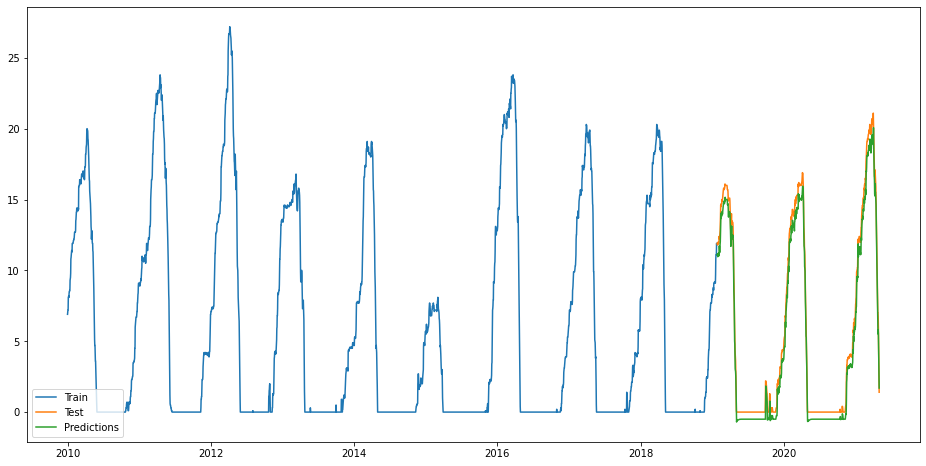

In [21]:
model.eval_test_data()

In [ ]:
model.predictions2('03/26/2020')

In [ ]:
model.true_forecasts

,0
Date,
2020-03-27,17.396507
2020-03-28,17.606572
2020-03-29,17.967115
2020-03-30,18.432297
2020-03-31,18.978614
2020-04-01,19.594518
2020-04-02,20.272881
2020-04-03,21.006100
2020-04-04,21.790170


## Regression Functions

### RegressionFun Class

In [ ]:
class RegressionFun():

  '''
  stations: list of stationtriplets, with the response station in the first position followed by the predictor station(s).  Ex. ['817:WA:SNTL', '711:WA:SNTL', '975:WA:SNTL']
  parameter_of_interest: can choose 'WTEQ', 'SNWD', 'PREC', 'PRCP', 'TAVG', 'TOBS', and others (https://www.nrcs.usda.gov/wps/portal/wcc/home/dataAccessHelp/webService/webServiceReference/!ut/p/z1/jc9NDoIwEAXgs3CCPqCWuqxNBFIiqdCAsyFdkSaKLozn1xg2LmyY3STfmx9GbGS0-FeY_TPcF3_99BcSk5Sapy1HU576HFactTtWJkMKNnxBnUlVyQ6m1JxD7XXRN10BcwCjLXn8KbUxHwEUHz8w-l0BWWew2hre7pBDpyuIvRgFvVhB5IrHzbkRoZ5VkrwBnC-XyQ!!/?1dmy&current=true&urile=wcm%3apath%3a%2Fwcc%2Bcontent%2Fhome%2Fdata%2Baccess%2Bhelp%2Fweb%2Bservice%2Fweb%2Bservice%2Breference#elementCodes).
  '''

  def __init__(self, stations, parameter_of_interest):

    self.stations = stations
    self.parameter_of_interest = parameter_of_interest
    
  def check_model(self, begindate, enddate, regression_model, test_size):

    '''
    Function checks model fit on train and test sets.  Use to check which stations result in the best fitting model.  Once the best model is found, it can be used in the make_predictions function to predict null values.
    
    begindate: non-null date in 'mm/dd/yyyy' format
    enddate: non-null date in 'mm/dd/yyyy' format
    regression_model: can be 'Ridge', 'Lasso', 'Huber', 'SVM', 'Random Forest', 'AdaBoost', 'GradientBoost'
    test_size: value between 0 and 1 that defines the percentage of the data to be used as the test_size
    '''

    #Download Data from AWDB Web Service
    data = getData(self.stations, self.parameter_of_interest, begindate, enddate)  #.dropna()
    assert (data is not None), 'The value associated with the begindate and/or enddate in the Air-Water Database (AWDB) is null.  Need to either select a different date(s) or update the value(s) using DMP in AWDB.'

    #Define Targets and Features (e.g. Response and Predictor Variables)
    target = data.iloc[:,0]
    features = data.iloc[:,1:]

    #Split into training and test sets
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=test_size, shuffle=False)
  
    #Choose Regression Model:
    regr = regressionModel(regression_model)
  
    #Fit model on training set
    regr.fit(features_train, target_train)

    #Make regression model usable in other class methods
    self.regr = regr

    #Run predictions on training features and test features
    target_train_pred = regr.predict(features_train)
    target_test_pred = regr.predict(features_test)

    #Print Root Mean Square Error for training and test sets:
    print('RMSE for training set', mean_squared_error(target_train, target_train_pred))
    print('RMSE for test set', mean_squared_error(target_test, target_test_pred))

    #Predictions plot

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y = target_train,
        x = target_train.index,
        mode = 'lines',
        name = 'Training Data'
    ))

    fig.add_trace(go.Scatter(
        y = target_train_pred,
        x = target_train.index,
        mode = 'lines',
        name = 'Model Predictions on Training Data'
    ))

    fig.add_trace(go.Scatter(
        y = target_test,
        x = target_test.index,
        mode = 'lines',
        name = 'Test Data'
    ))

    fig.add_trace(go.Scatter(
        y = target_test_pred,
        x = target_test.index,
        mode = 'lines',
        name = 'Model Predictions on Test Data'
    ))

    fig.update_yaxes(title_text = f"{self.parameter_of_interest}")
    fig.update_xaxes(title_text = 'Date') 

    fig.update_layout(
        showlegend=True,
        height=450,
        width=1200 
    )
    fig.show()

    # # # # # Regression Plot # # # # #

    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(
      x=features_train.iloc[:,0],
      y=target_train,
      mode='markers',
      hovertext = features_train.index,
      name =  'Response vs. Predictors'
    ))

    fig2.add_trace(go.Scatter(
      x=features_train.iloc[:,0],
      y=pd.DataFrame(target_train_pred.tolist()).iloc[:,0],
      mode='lines',
      hovertext = features_train.index,
      name = 'Model Fit'  
    ))
    
    fig2.update_yaxes(title_text = f'{self.stations[1:]} {self.parameter_of_interest}')
    fig2.update_xaxes(title_text = f'{self.stations[0]} {self.parameter_of_interest}')
    fig2.update_layout(
        showlegend=True,
        height=450,
        width=1200 
    )
    fig2.show()

    return regr
      
      
  def make_predictions(self, predict_begindate, predict_enddate):

    #Download Data from AWDB Web Service
    predict_data  = getData(self.stations, self.parameter_of_interest, predict_begindate, predict_enddate)

    predict_target = predict_data.iloc[:,0].fillna(0)
    predict_features = predict_data.iloc[:,1:].fillna(0)

    #Run predictions
    predictions = self.regr.predict(predict_features)
    
    #Plot predictions 
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y = predict_target,
        x = predict_target.index,
        mode = 'lines',
        name = f'{self.stations[0]} {self.parameter_of_interest}'
    )) 

    fig.add_trace(go.Scatter(
        y = predictions,
        x = predict_features.index,
        mode = 'lines',
        name = 'Model Predictions'
    )) 

    fig.update_layout(
      showlegend=True,
      height=650,
      width=1400,
      title={
          'text': "Model Predictions",
          'xanchor': 'center',
          'yanchor': 'top',
          'y':0.9,
          'x':0.4},
      xaxis_title = "Date",
      yaxis_title = f"{self.parameter_of_interest} (in)"
    )

    fig.show()  

### Other functions: Keep for now

In [ ]:
def Predictions(stations, parameter_of_interest, train_begindate, train_enddate, predict_begindate, predict_enddate, regression_model):

  # global predict_target, predict_features, train_target, train_features

  #Download Data from AWDB Web Service
  train_data = getData(stations, parameter_of_interest, train_begindate, train_enddate)
  predict_data  = getData(stations, parameter_of_interest, predict_begindate, predict_enddate)
  #Define Targets and Features (e.g. Dependent and Independent Variables)
  train_target = train_data.iloc[:,0].fillna(0)
  train_features = train_data.iloc[:,1:].fillna(0)

  predict_target = predict_data.iloc[:,0].fillna(0)
  predict_features = predict_data.iloc[:,1:].fillna(0)

  # Choose Regression Model:
  regr = regressionModel(regression_model)

  #Fit model to training set
  regr.fit(train_features, train_target)

  #Run predictions
  predictions = regr.predict(predict_features)
  
  #Plot predictions 
  fig = go.Figure()

  fig.add_trace(go.Scatter(
      y = predict_target,
      x = predict_target.index,
      mode = 'lines',
      name = f'{stations[0]} {parameter_of_interest}'
  )) 

  fig.add_trace(go.Scatter(
      y = predictions,
      x = predict_features.index,
      mode = 'lines',
      name = 'Model Predictions'
  )) 

  fig.update_layout(
    showlegend=True,
    height=650,
    width=1400,
    title={
        'text': "Model Predictions",
        'xanchor': 'center',
        'yanchor': 'top',
        'y':0.9,
        'x':0.4},
    xaxis_title = "Date",
    yaxis_title = f"{parameter_of_interest} (in)"
  )

  fig.show()

# Estimating Missing Data

In [ ]:
Blewett = RegressionFun(['352:WA:SNTL','507:WA:SNTL'], 'PREC')
Blewett.check_model('10/01/2020','02/26/2021','Ridge',0.3)  #https://stackoverflow.com/questions/48849540/random-forest-regression-accuracy-different-for-training-set-and-test-set

RMSE for training set 0.11941430703346664
RMSE for test set 1.9978289492908137


RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [ ]:
Blewett.make_predictions('02/01/2021','05/01/2021')

In [ ]:
#Aneroid Lake

Aneroid = RegressionFun(['302:OR:SNTL', '653:OR:SNTL'],'WTEQ')
Aneroid.check_model('11/01/2020', '11/29/2020', 'Ridge', 0.2)

RMSE for training set 0.23770631360509462
RMSE for test set 0.39786855592831727


RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [ ]:
Aneroid.make_predictions('11/01/2020','05/01/2021')

In [ ]:
#Morse Lake Predictions

Morse = RegressionFun(['642:WA:SNTL', '1085:WA:SNTL', '679:WA:SNTL'], 'WTEQ')
Morse.check_model('10/01/2020', '12/22/2020','Ridge', 0.2)

RMSE for training set 0.723321262148169
RMSE for test set 2.454167025684653


RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [ ]:
Morse.make_predictions('12/22/2020', '06/01/2021')

In [ ]:
 #Mt. Crag Predictions

crag = RegressionFun(['648:WA:SNTL', '1107:WA:SNTL','974:WA:SNTL'], 'WTEQ')
crag.check_model('11/10/2019','12/10/2020','Ridge',0.2)

RMSE for training set 7.647819967280692
RMSE for test set 0.9844792439434749


RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [ ]:
crag.make_predictions('01/01/2021','05/01/2021')

In [ ]:
 #Olallie Meadows Predictions

Olallie = RegressionFun(['672:WA:SNTL', '788:WA:SNTL', '898:WA:SNTL'],'WTEQ')
Olallie.check_model('01/01/2021','03/31/2021','Ridge',0.2)

RMSE for training set 1.1013893039320122
RMSE for test set 1.517951406136339


RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [ ]:
Olallie.make_predictions('01/01/2021', '06/01/2021')

In [ ]:
 #Thunder Basin Predictions
Thunder = RegressionFun(['817:WA:SNTL','975:WA:SNTL', '681:WA:SNTL' , '711:WA:SNTL'],'WTEQ')  #'975:WA:SNTL'  '681:WA:SNTL'  '711:WA:SNTL'
Thunder.check_model('01/01/2021', '02/28/2021', 'Ridge', 0.2)

RMSE for training set 0.06858814308560325
RMSE for test set 0.0419017392067233


RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [ ]:
Thunder.make_predictions('01/01/2021', '06/01/2021')

In [ ]:
#Sasse

In [ ]:
Sasse = RegressionFun(['734:WA:SNTL', '478:WA:SNTL'],'WTEQ')  #'478:WA:SNTL'  '791:WA:SNTL'  '788:WA:SNTL'
Sasse.check_model('12/01/2020', '05/15/2021', 'Ridge', 0.2)

RMSE for training set 0.5403704639102332
RMSE for test set 1.3930360605843681


RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [ ]:
Sasse.make_predictions('05/01/2021', '06/01/2021')

# Easy Pass  

In [ ]:
getData(['998:WA:SNTL', '990:WA:SNTL', '909:WA:SNTL'], 'SNWD', '11/01/2020', '04/02/2021')

The value associated with the begindate and/or enddate in the Air-Water Database (AWDB) is null.  Need to either select a different date(s) or update the value(s) using DMP in AWDB.


In [ ]:
Easy = RegressionFun(['998:WA:SNTL', '990:WA:SNTL', '909:WA:SNTL'], 'SNWD')  #'998:WA:SNTL'  '909:WA:SNTL'  '990:WA:SNTL'
Easy.check_model('11/01/2020', '04/01/2021', 'Ridge', 0.2)

RMSE for training set 45.653637512836646
RMSE for test set 62.32582935081321


RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [ ]:
Easy.make_predictions('04/01/2021', '06/01/2021')

TypeError: ignored